In [1]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5872 sha256=1369aa61d96bd562094d1b48f9091942a532ea76dfe569f6caf80b5a50e85167
  Stored in directory: /Users/solvd/Library/Caches/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [2]:
!pip install noisereduce

In [3]:
!pip install malaya_speech

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50450 sha256=a1526c2893bd890f02983307e8f4c95b8b5819dab0a6fc31953c1836272aa2c3
  Stored in directory: /Users/solvd/Library/Caches/pip/wheels/3e/b8/c5/b553d5e8b0249bd2859b3b6d7bb2a1849e7b01c6e8b64f6e87
Successfully built memoization


In [4]:
!pip install torch

In [11]:
pip install webrtcvad

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np 
import pandas as pd
import shutil
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import noisereduce as nr
from scipy.io import wavfile
import tensorflow 
import os
import malaya_speech
from malaya_speech import Pipeline


from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder
import seaborn as sn

In [13]:
from scipy import signal
import librosa.display

In [14]:
train_path = 'commands'
test_file = '/left/00b01445_nohash_0.wav'

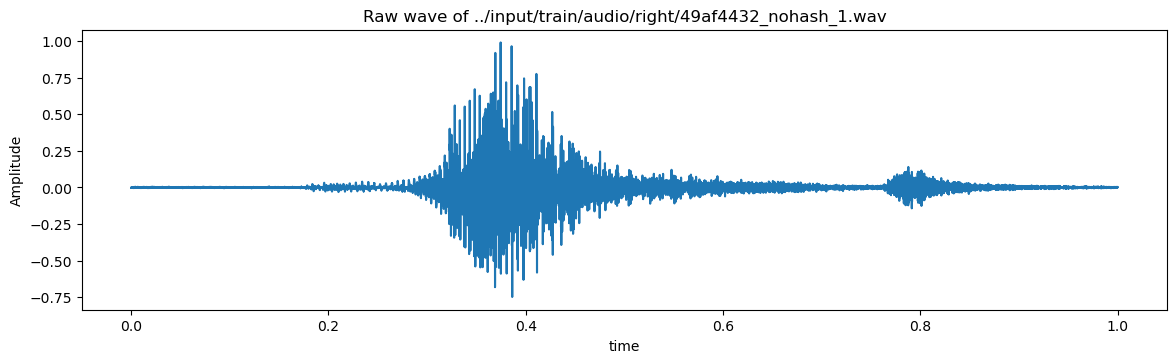

In [15]:
samples, sample_rate = librosa.load(train_path + test_file, sr=16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/right/49af4432_nohash_1.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
fig.show()

In [16]:
ipd.Audio(samples, rate=sample_rate)

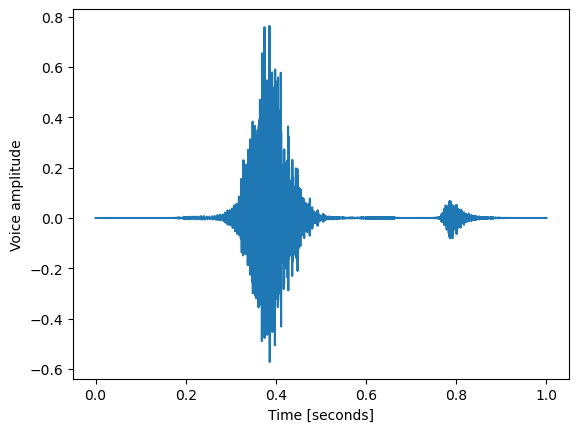

In [17]:
time = np.linspace(0, len(samples - 1) / sample_rate, len(samples - 1))
reduced_noise1 = nr.reduce_noise(y=samples, sr=sample_rate,stationary=True)
plt.plot(time, reduced_noise1)  # plot in seconds
plt.xlabel("Time [seconds]")
plt.ylabel("Voice amplitude")
plt.show()

In [18]:
ipd.Audio(reduced_noise1, rate=sample_rate)

In [19]:
#Silence Removal
vad = malaya_speech.vad.webrtc()
y=reduced_noise1
y_= malaya_speech.resample(y, sample_rate, 16000)
y_ = malaya_speech.astype.float_to_int(y_)
frames = malaya_speech.generator.frames(y, 30, sample_rate)
frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]
y_ = malaya_speech.combine.without_silent(frames_webrtc)
y_

array([-7.5932556e-05, -7.8418576e-05, -8.0812119e-05, ...,
       -1.4452168e-07,  1.7505888e-09,  1.4744687e-07], dtype=float32)

In [20]:
ipd.Audio(y_, rate = sample_rate)

In [21]:
zero = np.zeros((1*sample_rate-y_.shape[0]))
signal = np.concatenate((y_,zero))
signal.shape
time = np.linspace(0, len(signal - 1) / sample_rate, len(signal - 1))

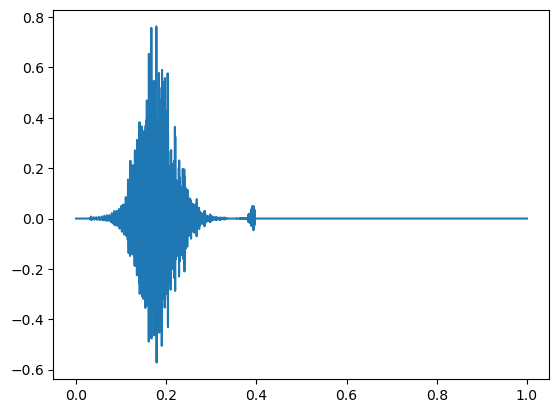

In [22]:
plt.plot(time,signal)

In [23]:
labels = os.listdir(train_path)
labels

['right', 'go', 'no', 'left', 'stop', 'up', 'down', 'yes', 'on', 'off']

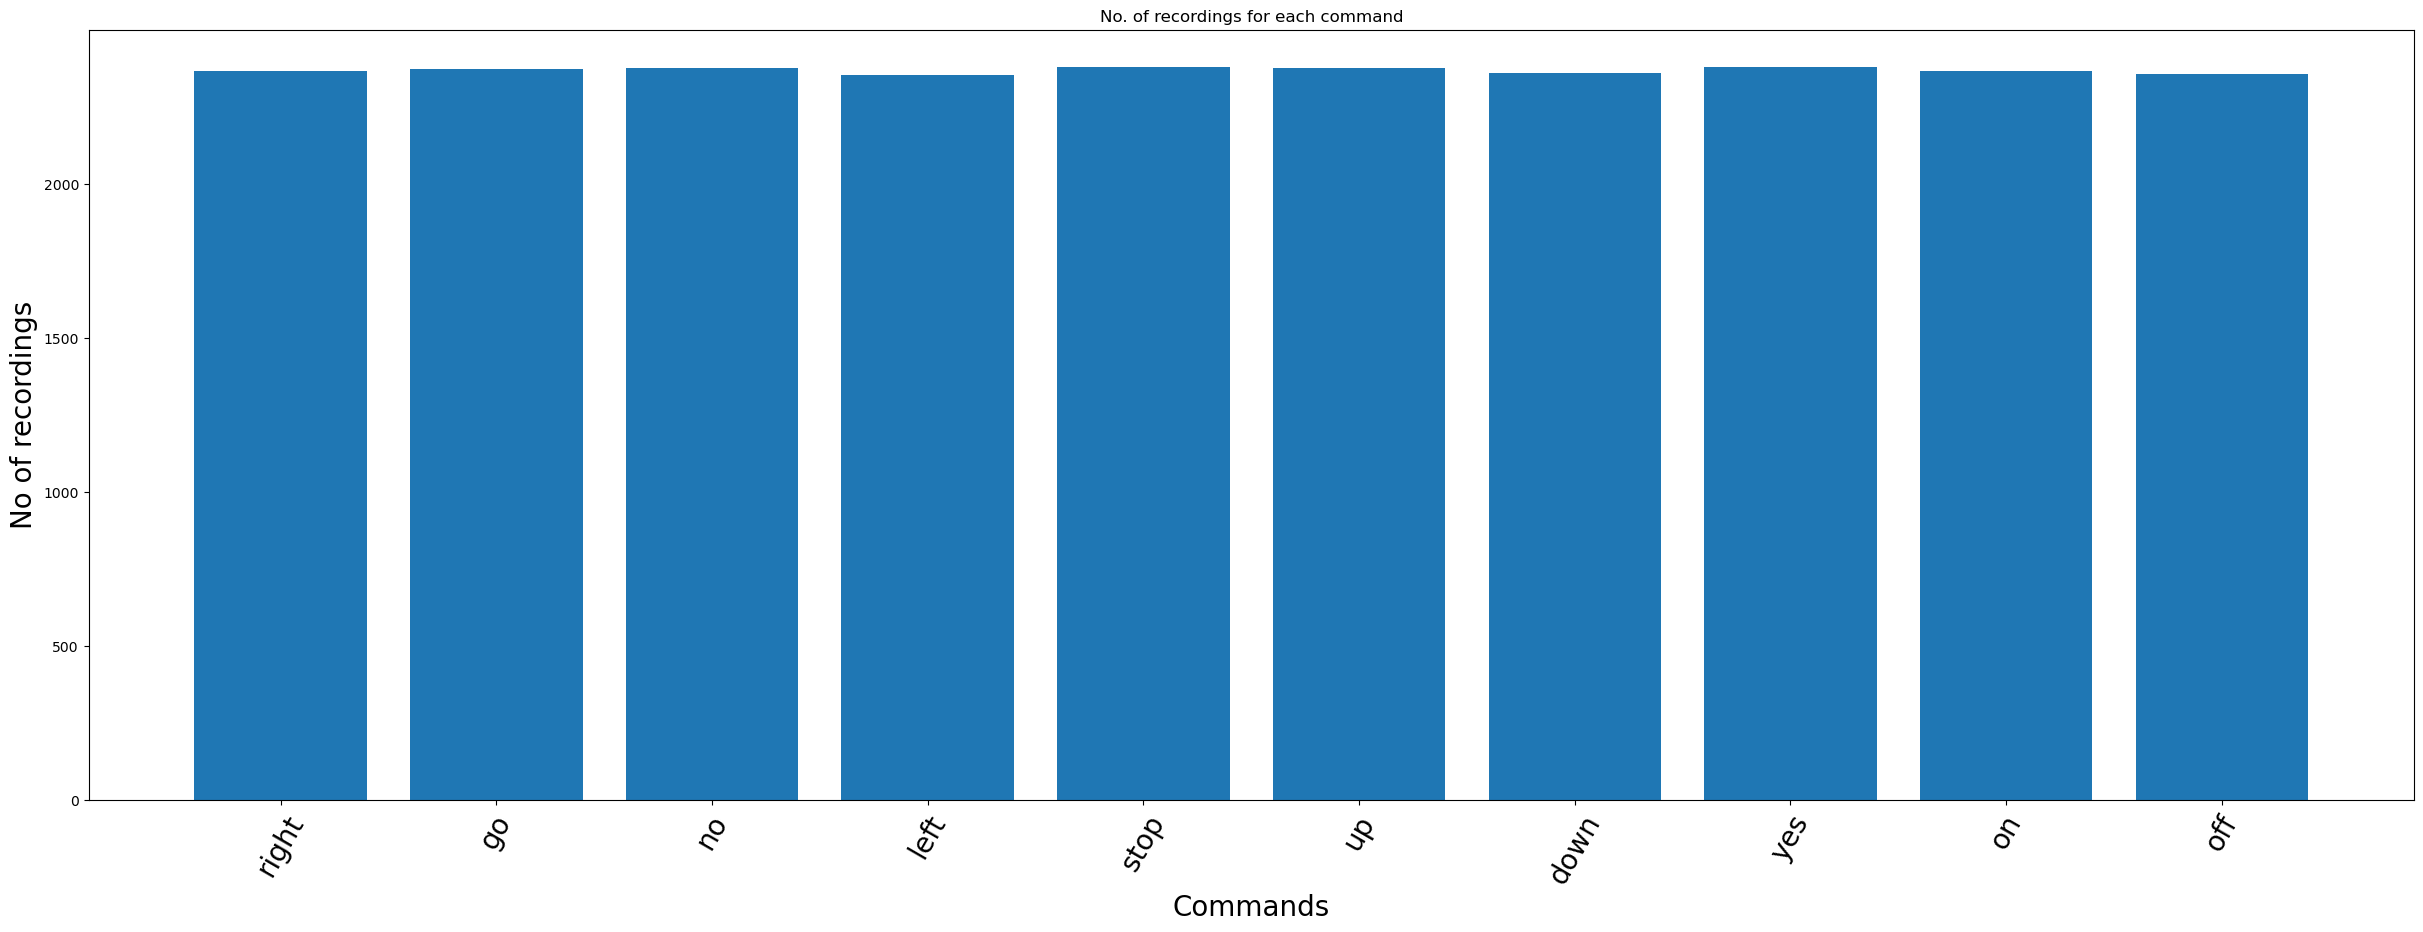

In [24]:
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,10))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=20)
plt.ylabel('No of recordings', fontsize=20)
plt.xticks(index, labels, fontsize=20, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [25]:
sr=16000
vad = malaya_speech.vad.webrtc()
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_path + '/' + label + '/' + wav, sr = 16000)
        samples = nr.reduce_noise(y=samples, sr=sr,stationary=True)
        y_= malaya_speech.resample(samples, sr, 16000)
        y_ = malaya_speech.astype.float_to_int(y_)
        frames = malaya_speech.generator.frames(samples, 30, sr)
        frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
        frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]
        y_ = malaya_speech.combine.without_silent(frames_webrtc)
        zero = np.zeros(((1*sample_rate+4000)-y_.shape[0]))
        signal = np.concatenate((y_,zero))
        all_wave.append(signal)
        all_label.append(label)

right
go
no
left
stop
up
down
yes
on
off


(23682, 20000)
(23682,)
right


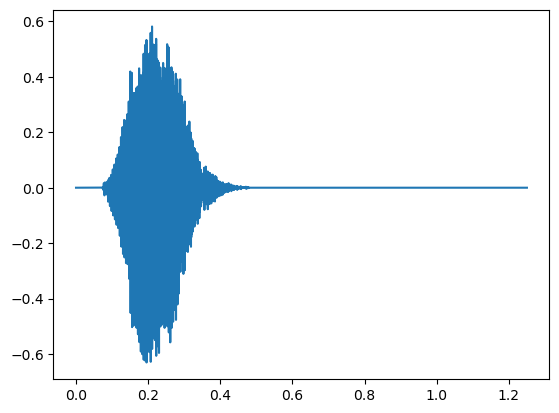

In [26]:
print(np.array(all_wave).shape)
print(np.array(all_label).shape)
time = np.linspace(0, len(signal - 1) / sample_rate, len(signal - 1))
plt.plot(time,np.array(all_wave)[2000,:])
print(np.array(all_label)[2000])
ipd.Audio(np.array(all_wave)[2000,:], rate = sr )

In [27]:
all_mfcc=[]
for wave in all_wave:
    i=0
    mfcc_feat = mfcc(wave , sample_rate, winlen=256/sample_rate, winstep=256/(2*sample_rate), numcep=13, nfilt=26, nfft=256,
                 lowfreq=0, highfreq=sample_rate/2, preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=np.hamming)
    mfcc_feat= np.transpose(mfcc_feat)
    all_mfcc.append(mfcc_feat)

In [28]:
print(np.array(all_mfcc).shape)
print(np.array(all_label).shape)
d1=np.array(all_mfcc).shape[1]
d2=np.array(all_mfcc).shape[2]
d=d1*d2
print(d)

(23682, 13, 156)
(23682,)
2028


In [29]:
op_mfcc=np.array(all_mfcc)
op_mfcc=op_mfcc.reshape(23682, -1)
op_mfcc.shape

(23682, 2028)

In [30]:
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
classes

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

In [31]:
from keras.optimizers import SGD
from keras.constraints import maxnorm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [32]:
y=tensorflow.keras.utils.to_categorical(y, num_classes=len(labels), dtype='float32')
y.shape

(23682, 10)

In [33]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val= train_test_split(op_mfcc,np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [34]:
print(x_tr.shape)
print(y_tr.shape)
print(x_val.shape)
print(y_val.shape)

(18945, 2028)
(18945, 10)
(4737, 2028)
(4737, 10)


In [35]:
#Model Architecture
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_shape=(d,), kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax' , kernel_constraint=maxnorm(3)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              2029000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10010     
                                                                 
Total params: 2,039,010
Trainable params: 2,039,010
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [38]:
history=model.fit(x_tr, y_tr,validation_data=(x_val,y_val), epochs=100, batch_size=32)

Epoch 1/100


2023-05-12 11:44:53.556326: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


593/593 [==============================] - 4s 6ms/step - loss: 0.8426 - accuracy: 0.7258 - val_loss: 0.5993 - val_accuracy: 0.8168
Epoch 2/100
593/593 [==============================] - 3s 6ms/step - loss: 0.6949 - accuracy: 0.7787 - val_loss: 0.5459 - val_accuracy: 0.8412
Epoch 3/100
593/593 [==============================] - 3s 6ms/step - loss: 0.6619 - accuracy: 0.7890 - val_loss: 0.5264 - val_accuracy: 0.8543
Epoch 4/100
593/593 [==============================] - 3s 6ms/step - loss: 0.6184 - accuracy: 0.8068 - val_loss: 0.5101 - val_accuracy: 0.8533
Epoch 5/100
593/593 [==============================] - 3s 6ms/step - loss: 0.6022 - accuracy: 0.8106 - val_loss: 0.4976 - val_accuracy: 0.8577
Epoch 6/100
593/593 [==============================] - 3s 6ms/step - loss: 0.5964 - accuracy: 0.8129 - val_loss: 0.5038 - val_accuracy: 0.8524
Epoch 7/100
593/593 [==============================] - 3s 6ms/step - loss: 0.5904 - accuracy: 0.8144 - val_loss: 0.5150 - val_accuracy: 0.8493
Epoch 8/100

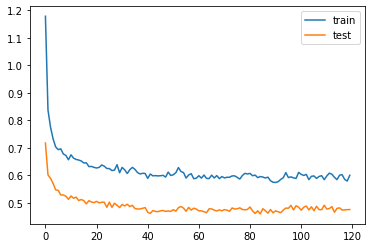

In [80]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

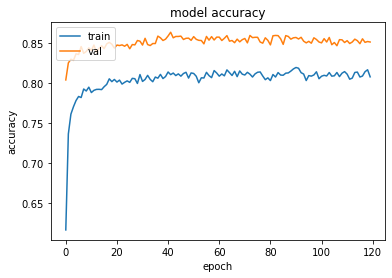

In [82]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [83]:
y_predict=model.predict(x_val)
conf_mat=tensorflow.math.confusion_matrix(np.argmax(y_val,axis=1) , np.argmax(y_predict,axis=1))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: tensorflow_probability is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: tensorflow_probability is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
149/149 [==============================] - 1s 3ms/step


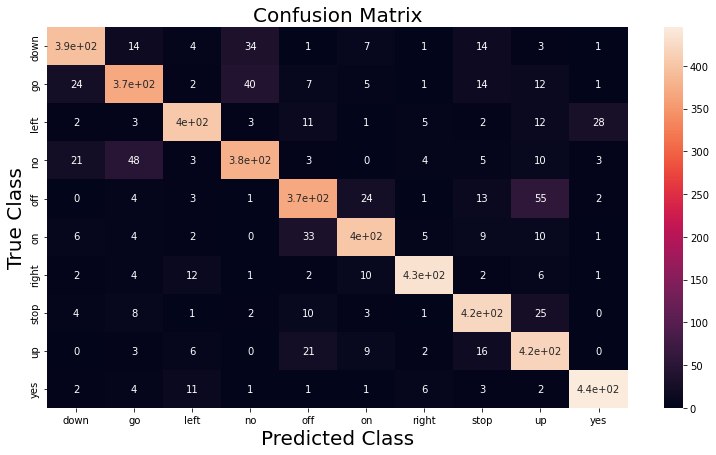

In [84]:
df_cm = pd.DataFrame(np.array(conf_mat), index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (13,7))
ax = sn.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel("True Class"     , fontsize=20)
plt.xlabel("Predicted Class", fontsize=20)
plt.show()